--------------
# <center>TP n° 2 : $k$-plus proches voisins, analyse discriminante linéaire et régression logistique</center>
-------------------
Thomas KOCH                                                      

***Information :***
*Les réponses textuelles aux questions posées seront sous la forme suivante :*
>Réponse à la question

A RENDRE POUR LE 27/11/19 23h59.                
## <center>- Rappels de classification -</center>

### Génération artificielle de données

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les
visualiser facilement) à savoir $p = 2$ dans le formalisme ci-dessus. On reprend en partie les jeux de données artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

#### Question 1 : Etudions les fonctions `rand_bi_gauss`, `rand_tri_gauss`, `rand_clown` et `rand_checkers`

In [1]:
###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D


In [2]:
###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


Que renvoient ces fonctions ? À quoi correspond la dernière colonne ?

>* La fonction `rand_bi_gauss` mélange aléatoirement 2 distributions gaussiennes de paramètres respectifs ***(mu1, sigma1)*** et ***(mu2, sigma2)***. Ces paramètres sont en fait le couple ***(moyenne, variance)*** de chaque distribution. Le nombre de points généré pour chaque distribution est respectivement de ***n1*** et ***n2***.

>* La fonction `rand_tri_gauss` mélange aléatoirement 3 distributions gaussiennes selon le même principe que `rand_bi_gauss`.

>* La fonction `rand_clown` mélange aléatoirement 2 distributions :
    * une parabolique de variance ***sigma*** ;
    * une distribution de moyenne nulle ;
    

>* La fonction `rand_checkers` génère un damier de manière aléatoire.

Génération des données pour `rand_bi_gauss` :

In [3]:
n1 = 100
n2 = 100
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

X1.shape, y1.shape

((200, 2), (200,))

Génération des données pour `rand_tri_gauss` :

In [4]:
n1=50
n2=50
n3=50
mu1=[1., 1.]
mu2=[-1., -1.]
mu3 = [1., -1.]
sigma1=[0.9, 0.9]
sigma2=[0.9, 0.9]
sigma3=[0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

X2.shape, y2.shape

((150, 2), (150,))

Génération des données pour `rand_clown` :

In [5]:
n1 = 100
n2 = 100
sigmas1 = 0.1
sigmas2 = 0.2
X3, y3 = rand_clown(n1, n2, sigmas1, sigmas2)

X3.shape, y3.shape

((200, 2), (200,))

Génération des données pour `rand_checkers` :

In [6]:
n1 = 150
n2 = 150
sigma = 0.9
X4, y4 = rand_checkers(n1, n2, sigma)

X4.shape, y4.shape

((288, 2), (288,))

#### Question 2 : Affichons les jeux de données générées avec chacune des fonctions à l'aide de la fonction `plot_2d`

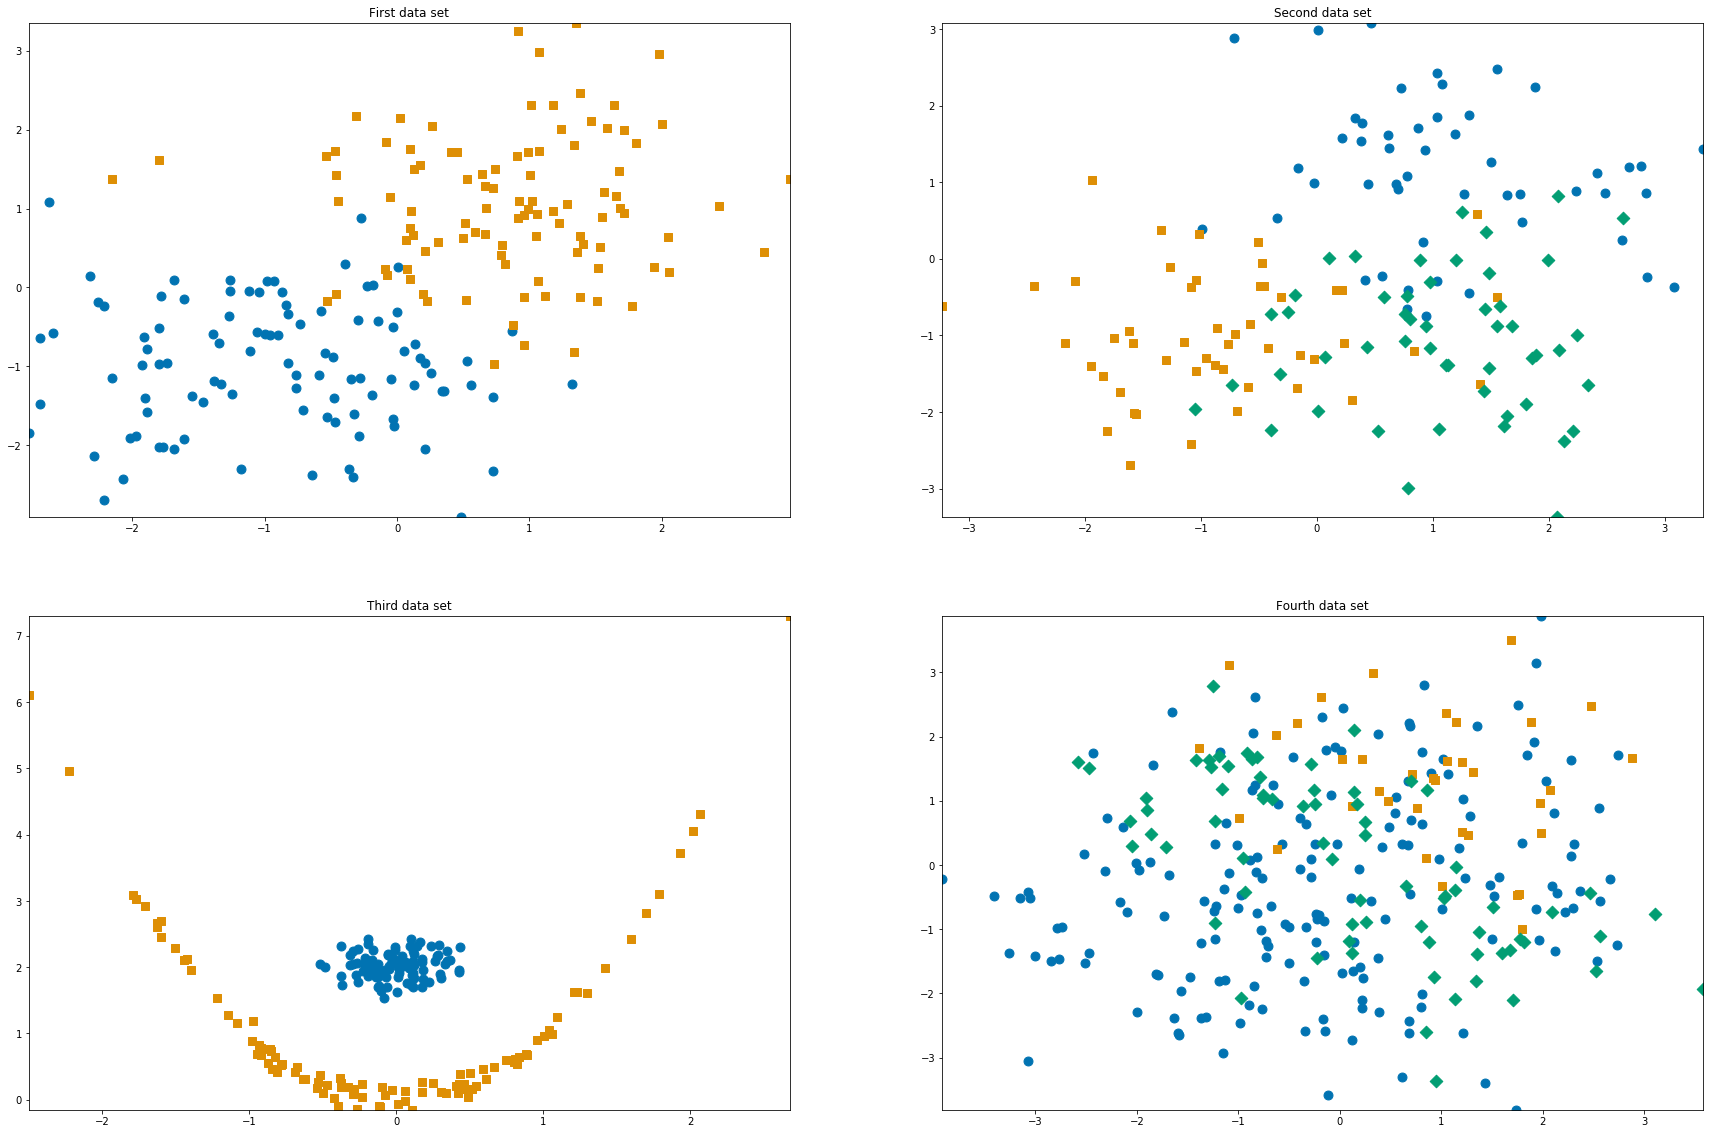

In [7]:
###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)
###############################################################################


        
plt.close("all")

plt.figure(1, figsize=(30, 15))

plt.subplot(221)
plt.title('First data set')
plot_2d(X1, y1)

plt.subplot(222)
plt.title('Second data set')
plot_2d(X2, y2)

plt.subplot(223)
plt.title('Third data set')
plot_2d(X3, y3)

plt.subplot(224)
plt.title('Fourth data set')
plot_2d(X4, y4)

plt.show()

>**Remarques :**

>* Les données des jeux 1 et 2 pourront facilement être séparées linéairement en appliquant par exemple une analyse discrimante linéaire (LDA en anglais, qu'on peut retrouver dans *sklearn*).

>* Les données du jeu 3 seront en revanche plus facilement séparables avec un classifieur k-nn.

## <center>- La méthode des k-plus proches voisins -</center>
### Approche intuitive
L’algorithme des $k$-plus proches voisins ($k-nn$ : pour $k-nearest neighbors$ en anglais) est un algorithme intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque d’étiquettes.                    
Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point $x$ on commence par déterminer l’ensemble de ses $k$-plus proches voisins parmi les points d’apprentissage que l’on note $Vk(x)$ (bien sûr on doit choisir $1 ≤ k ≤ n$ pour que cela ait un sens). La classe que l’on affecte au nouveau point $x$ est alors la classe majoritaire dans l’ensemble $Vk(x)$. Une illustration de la méthode est donnée en Figure 1 pour le cas de trois classes.

#### Question 3 : Proposons une version adaptée de cette méthode pour la régression, i.e., quand les observations $y$ sont à valeurs réelles : $Y = \mathbb{R}$.

>Une version adaptée de cette méthode pour la régression serait d'utiliser la moyenne des classes sur les plus proches voisins du point considéré.

### Approche formelle
Pour définir précisément la méthode, il faut commencer par choisir une distance $d : \mathbb{R}^p \times \mathbb{R}^p \mapsto \mathbb{R}$

Pour un nouveau point $x$, on définit alors l’ensemble de ses $k$-plus proches voisins $Vk(x)$ au sens de de cette distance. 

#### Question 4 : Écrivons notre propre classe `KNNClassifier` avec les méthodes d’apprentissage `fit` et de classification `predict`

Nous choisirons une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans $Vk(x)$. Nous vérifierons la validité des résultats en les comparant à ceux de la classe `KNeighborsClassifier` de ***scikit-learn*** en utilisant le jeu de données #2. Nous porposerons notre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).              

Pour plus d’information sur les classes on peut consulter le lien suivant :  http://docs.python.org/3/tutorial/classes.html.

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

class KNNClassifier(BaseEstimator, ClassifierMixin):
#""" Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        dist =  pairwise_distances(X, self.X, 'euclidean')
        ind = np.argsort(dist, axis=1)
        y = np.zeros((X.shape[0],))
        
        for p in range(X.shape[0]):
            list_val = []
            for i in range(self.n_neighbors):
                #print(self.y[ind[0,i]])
                list_val.append(self.y[ind[p,i]])
            y[p] = Counter(list_val).most_common() [0][0]
        return y

>Testons simplement notre classifieur maison sur un petit jeu de données avant de passer à l'échelle

In [13]:
classifier = KNNClassifier(n_neighbors=5)
classifier.fit(X2, y2)
#X0 = [[-1., -1.], [0., 0.]]
X0 = np.array([[-1., -1.], [0., 0.], [2., 2.], [2, -2]])
classifier.predict(X0)

array([2., 2., 1., 3.])

>On obtient donc un tableau qui nous classifie les points \[-1, -1\], \[0, 0\], \[2, 2\], \[2, -2\] par rapport au deuxième jeu de données. Le résultat donne :
* \[-1, -1\] dans classe 2
* \[0, 0\] dans classe 2
* \[2, 2\] dans classe 1
* \[2, -2\] dans classe 3

> Maintenant que notre classifieur semble fonctionner, nous allons, comme le suggère l'énoncé, utiliser les observations d'indice pair pour le set d'apprentissage et d'indice impair pour le set de test, puis nous comparerons les résultats de notre classifieur avec la fonction de `sklearn`

In [24]:
classifier = KNNClassifier(n_neighbors=5)
classifier.fit(X2[::2], y2[::2])
classifier_predictions = classifier.predict(X2[1::2])
print(classifier_predictions)

[1. 3. 2. 2. 1. 3. 2. 1. 1. 1. 1. 2. 1. 3. 3. 1. 1. 2. 1. 2. 3. 2. 2. 3.
 1. 2. 2. 3. 3. 2. 3. 3. 2. 3. 1. 3. 2. 3. 3. 2. 3. 1. 1. 2. 3. 3. 2. 1.
 3. 2. 2. 2. 1. 3. 2. 3. 3. 3. 1. 1. 2. 3. 2. 1. 1. 3. 1. 3. 1. 3. 3. 2.
 1. 2. 1.]


In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh2 = KNeighborsClassifier(n_neighbors=5)
neigh2.fit(X2[::2], y2[::2]) 
neigh2_predictions = neigh2.predict(X2[1::2])
print(neigh2_predictions)

[1. 3. 2. 2. 1. 3. 2. 1. 1. 1. 1. 2. 1. 3. 3. 1. 1. 2. 1. 2. 3. 2. 2. 3.
 1. 2. 2. 3. 3. 2. 3. 3. 2. 3. 1. 3. 2. 3. 3. 2. 3. 1. 1. 2. 3. 3. 2. 1.
 3. 2. 2. 2. 1. 3. 2. 3. 3. 3. 1. 1. 2. 3. 2. 1. 1. 3. 1. 3. 1. 3. 3. 2.
 1. 2. 1.]


In [26]:
classifier_predictions == neigh2_predictions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

> On retrouve donc bien les mêmes résultats entre notre algorithme et l'implémentation de `sklearn.neighbors`. Visualisons, par curiosité, les frontières définies.

In [42]:
###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, aspect='auto', colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1], aspect='auto')
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter([X[i, 0]], [X[i, 1]], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


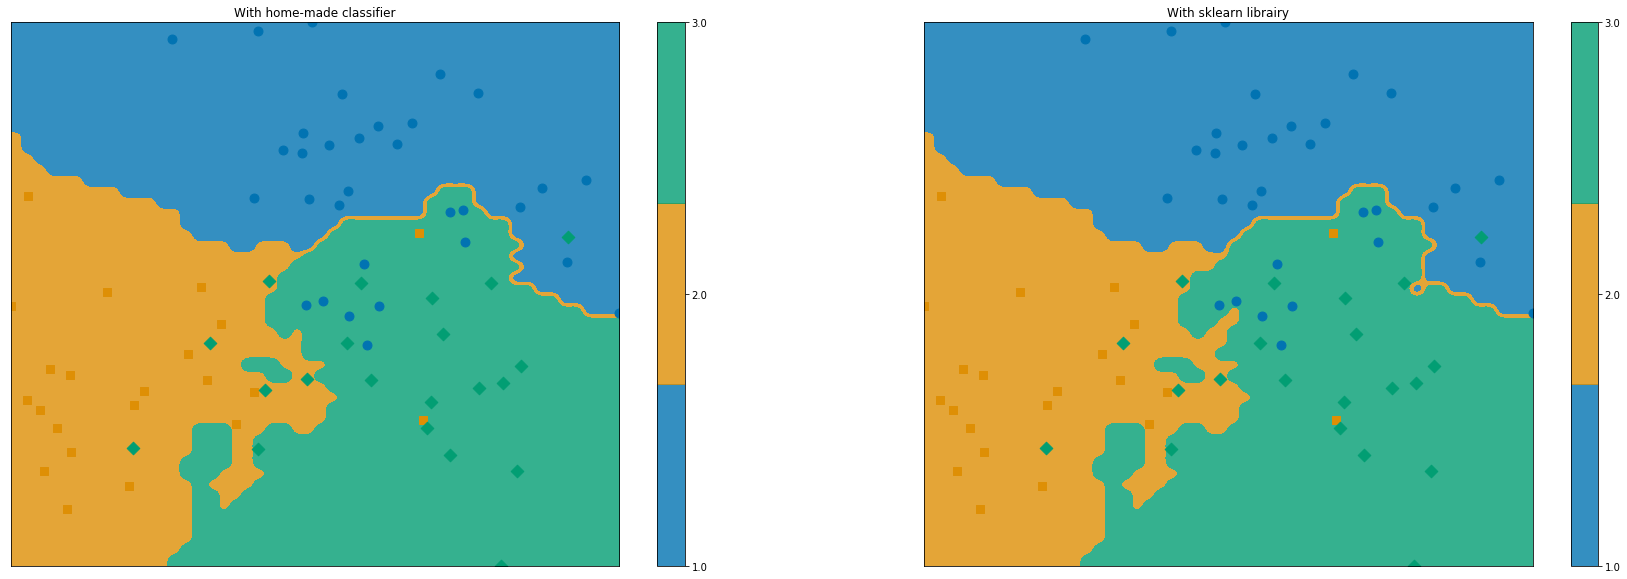

In [47]:
plt.figure(figsize=(30,10))

plt.subplot(121)
plt.title("With home-made classifier")
def f_classifier(x):
    return classifier.predict(x)
frontiere_new(f_classifier, X2[1::2], y2[1::2])

plt.subplot(122)
plt.title("With sklearn librairy")
def f_neigh2(x):
    return neigh2.predict(x)
frontiere_new(f_neigh2, X2[1::2], y2[1::2])

>Il est intéressant de noter que les frontières sont quasiment identiques, mais pas exactement dans tous les détails comme le montrent les figures ci-dessus.

#### Question 5 : Faisons tourner sur les quatre exemples de jeux de données cet algorithme de classification, en utilisant la distance euclidienne classique $d(x, v) = ||x − v||_2$ et $k = 5$ 
Visualisons les règles de classification obtenues en utilisant la fonction `frontiere_new`. 

>Nous utiliserons la même règle que précedemment pour entraîner et tester nos modèles.

In [38]:
neigh1 = KNeighborsClassifier(n_neighbors=5)
neigh1.fit(X1[::2], y1[::2])
neigh1_predictions = neigh1.predict(X1[1::2])
print(neigh1_predictions)

neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh3.fit(X3[::2], y3[::2])
neigh3_predictions = neigh3.predict(X3[1::2])
print(neigh3_predictions)

neigh4 = KNeighborsClassifier(n_neighbors=5)
neigh4.fit(X4[::2], y4[::2])
neigh4_predictions = neigh4.predict(X4[1::2])
print(neigh4_predictions)

[ 1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.
  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.
  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.
  1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.
  1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.
  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.]
[ 1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1.
  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.
  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 3. 1. 1. 1. 1. 3. 1. 1. 1. 1.
 1. 1. 1. 3. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 3. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 3. 1. 1. 1. 1. 1. 3. 2. 1. 1. 1. 1. 1. 

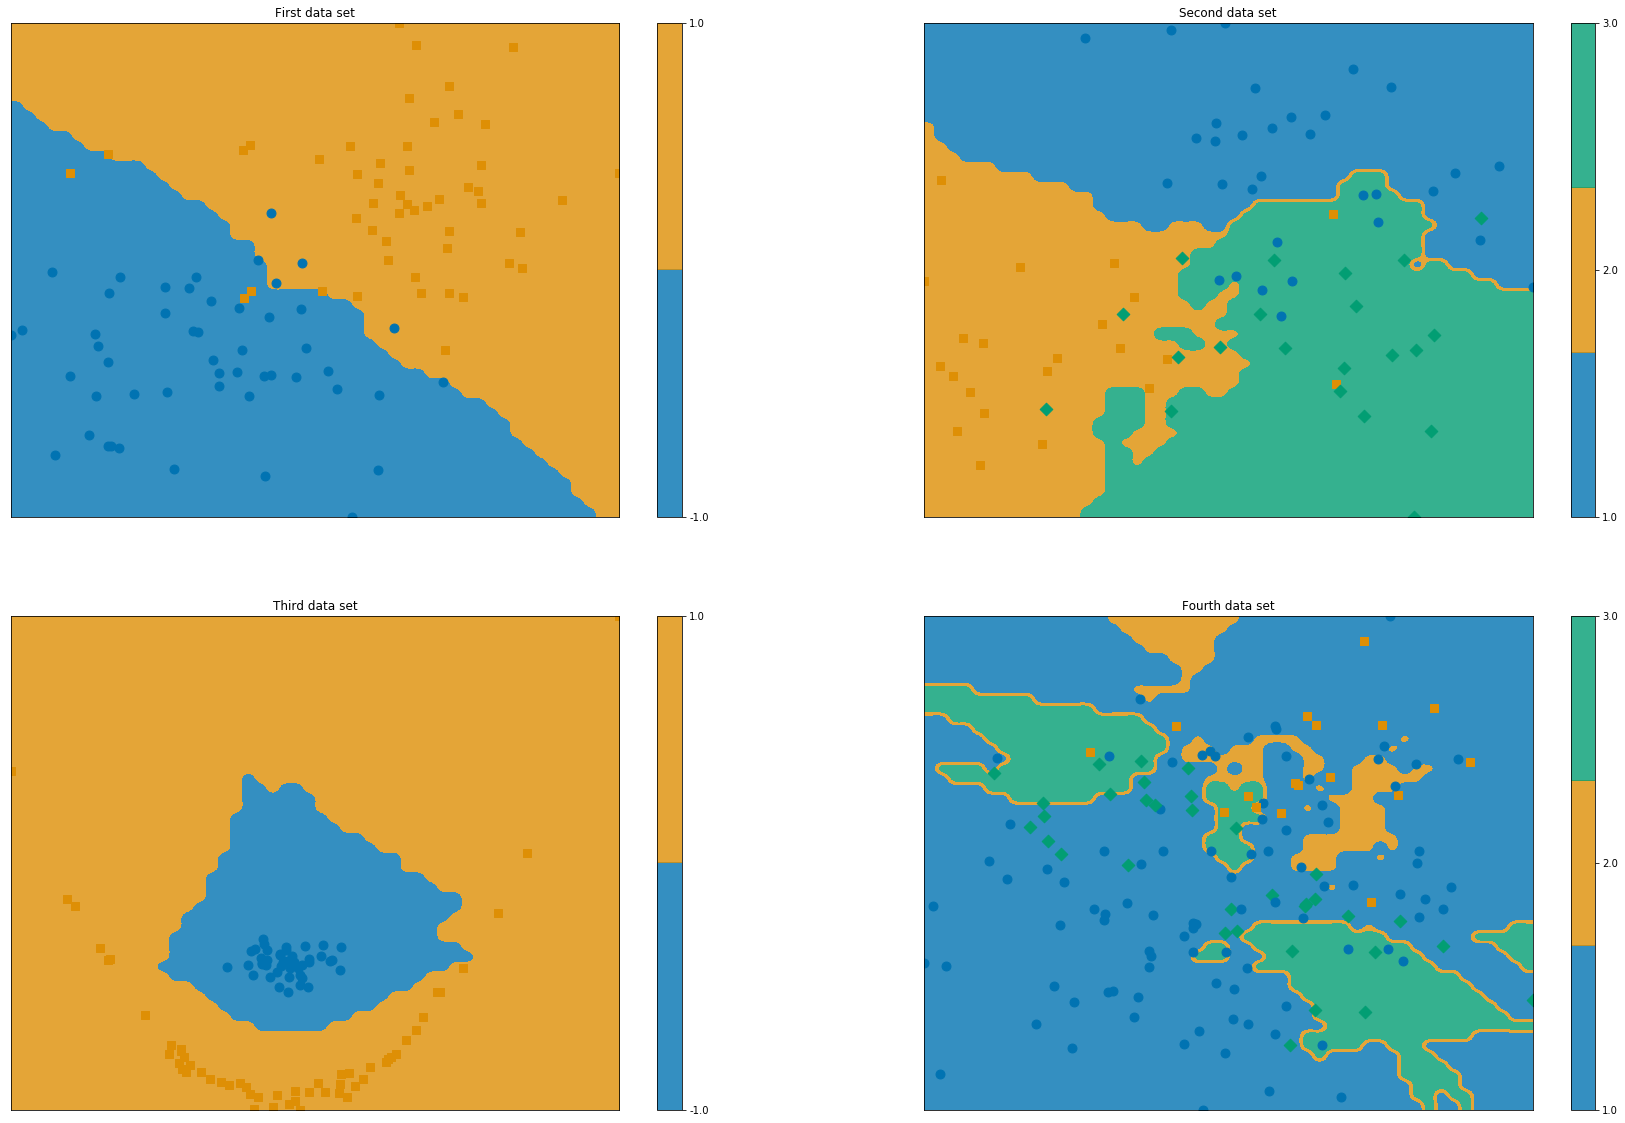

In [45]:
plt.figure(figsize=(30, 20))

plt.subplot(221)
plt.title('First data set')
def f_neigh1(x):
        return neigh1.predict(x)
frontiere_new(f_neigh1, X1[1::2], y1[1::2])

plt.subplot(222)
plt.title('Second data set')
def f_neigh2(x):
        return neigh2.predict(x)
frontiere_new(f_neigh2, X2[1::2], y2[1::2])

plt.subplot(223)
plt.title('Third data set')
def f_neigh3(x):
        return neigh3.predict(x)
frontiere_new(f_neigh3, X3[1::2], y3[1::2])

plt.subplot(224)
plt.title('Fourth data set')
def f_neigh4(x):
        return neigh4.predict(x)
frontiere_new(f_neigh4, X4[1::2], y4[1::2])

## Question 6 : Pour les observations d’indice pairs du jeu de données #2, faisons varier le nombre k de voisins pris en compte : $k = 1, 2, . . . , n$
Que devient la méthode dans le cas extrême où $k = 1$ ? $k = n$ ? Afficher ces cas sur les données étudiées en utilisant la fonction `frontiere_new` et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

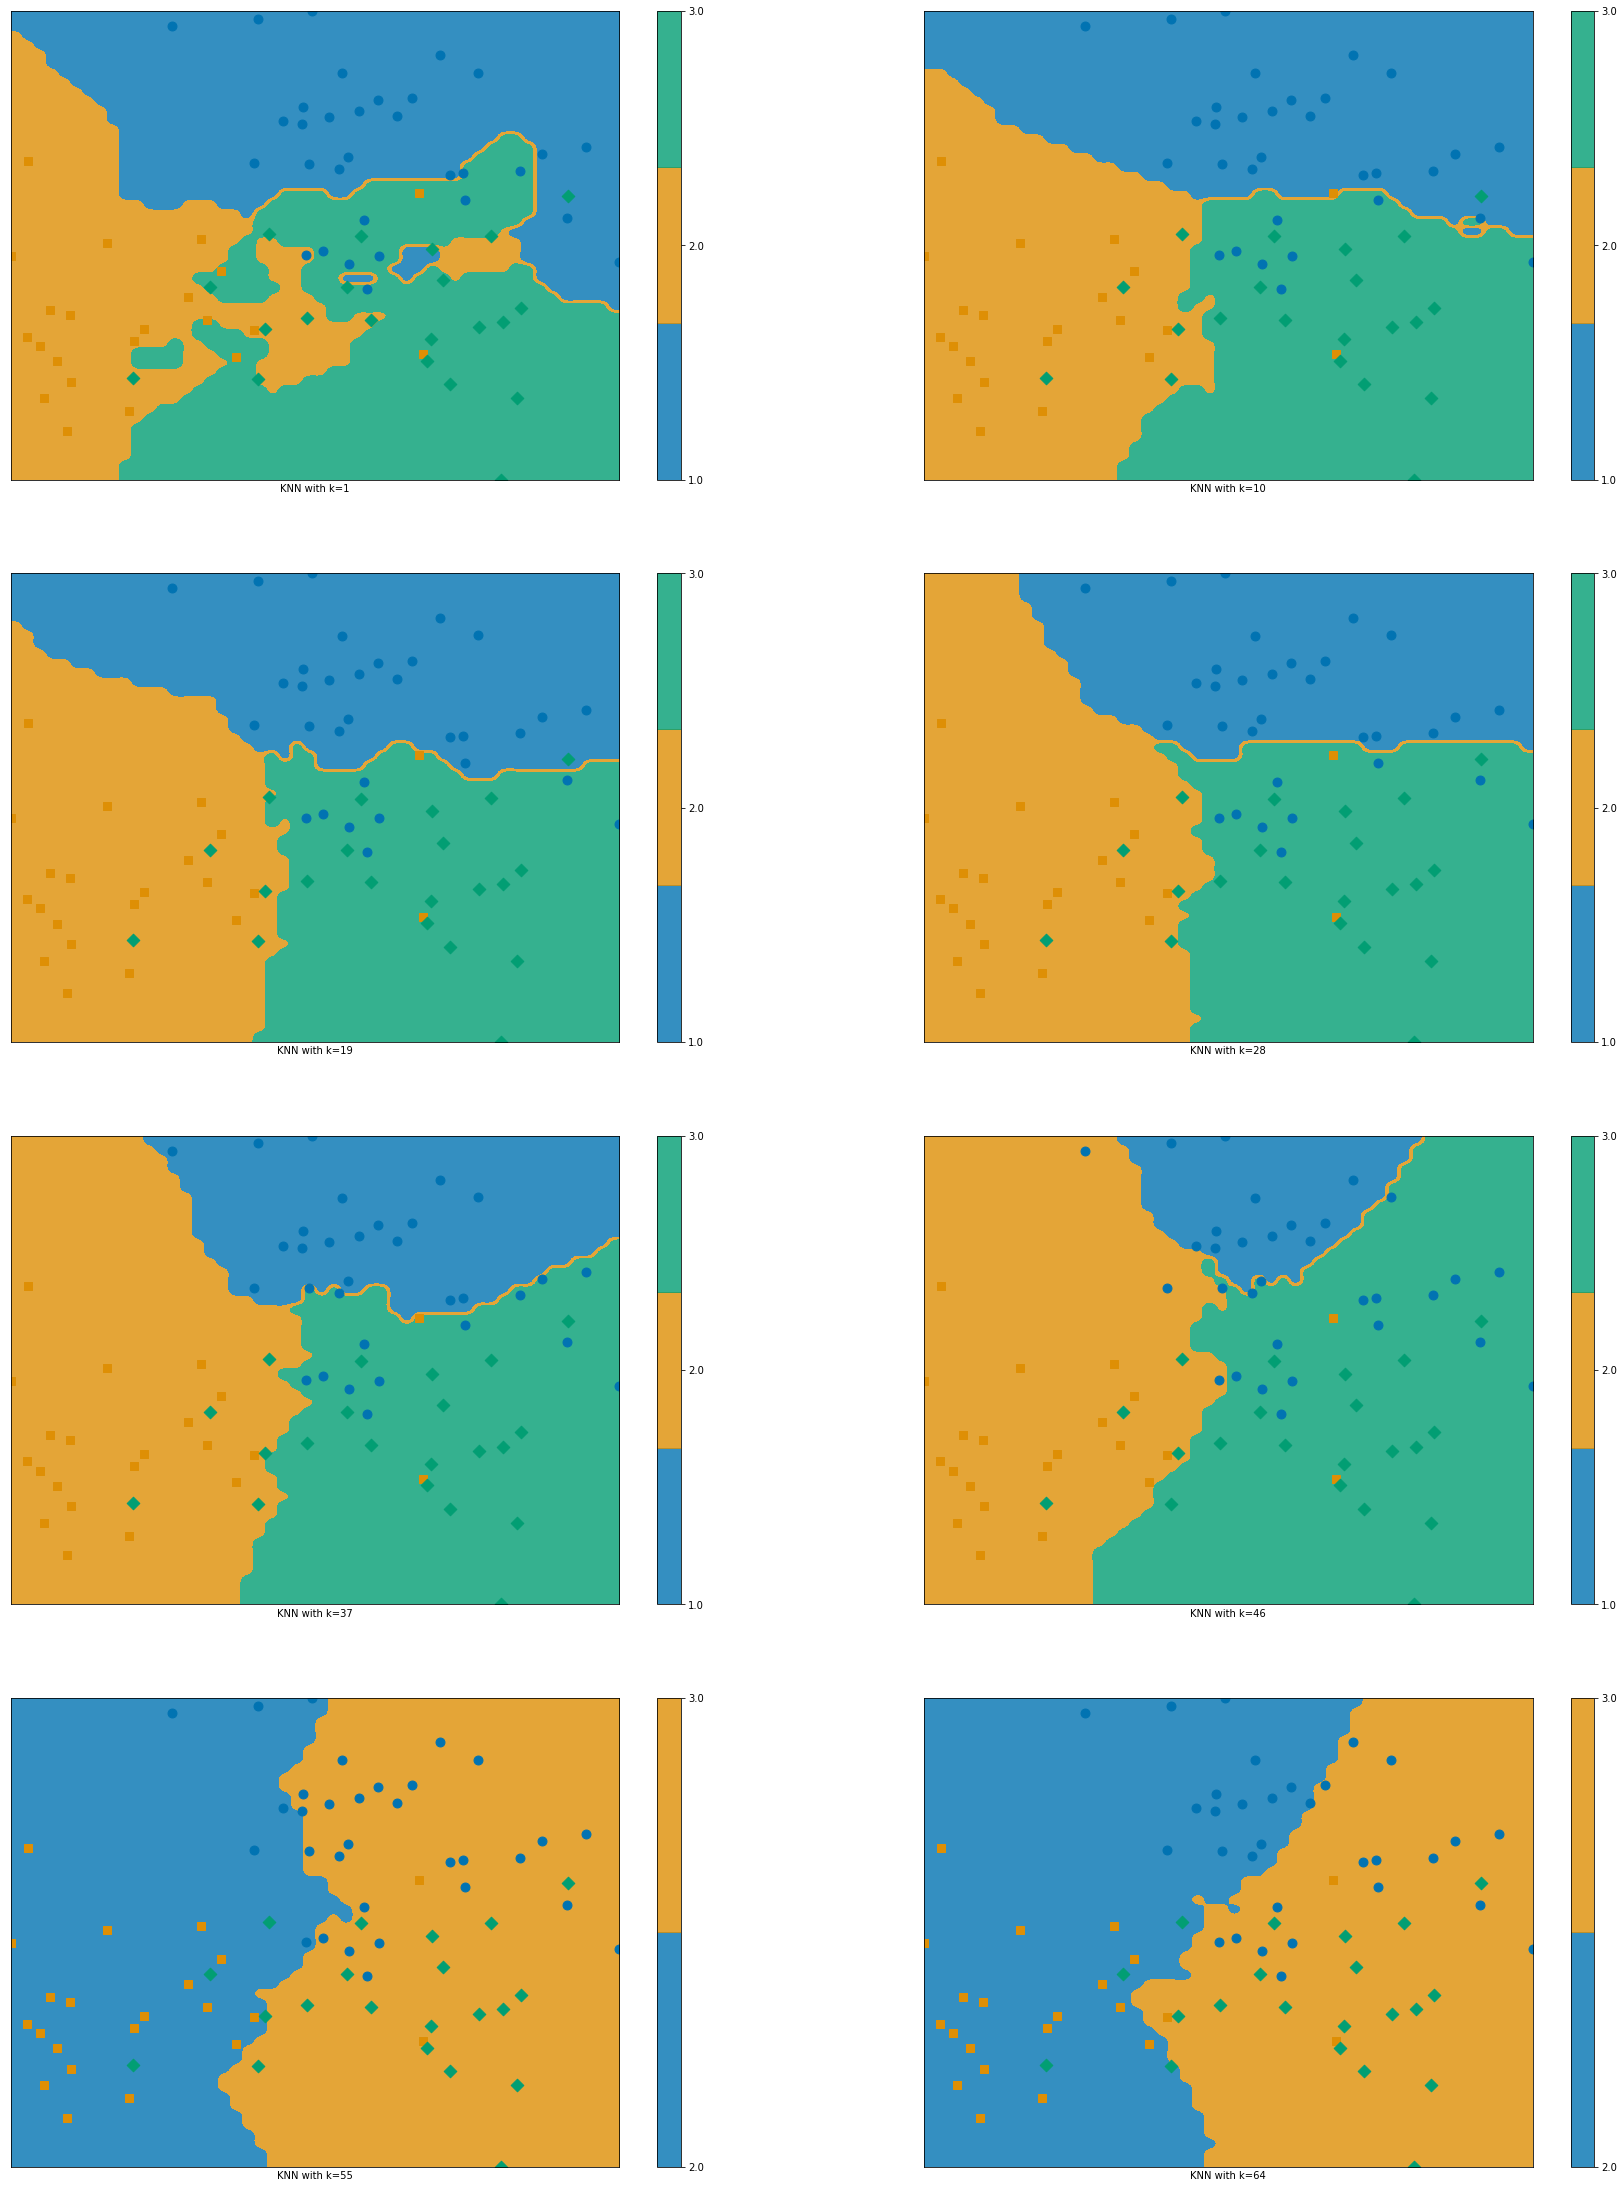

In [54]:
plt.figure(3, figsize=(30, 50))

i = 0
for n_neighbors in range(1, 65, 9): # il faut n_neighbors <= n_samples,  avec n_samples = 75 dans notre cas
    i = i + 1
    knn_classifier = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn_classifier.fit(X2[::2],y2[::2])
    plt.subplot(5, 2, i)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    def f_knn(x):
        return knn_classifier.predict(x)
    frontiere_new(f_knn, X2[1::2], y2[1::2])

plt.show()

>**Interprétation :**           
* Plus k est grand, plus les frontières se simplifient mais on y perd alors en terme de justesse de classification. Ainsi, dans notre exemple à partir de k = 55, il n'y a plus qu'une seule frontière pour deux couleurs de classifications.
* Aussi, on peut dire que :
    * Quand k = 1 la frontière est très complexe
    * Quand k = n la frontière se simplifie mais ne permet plus vraiment de bien classifier

#### Question 7 : Pondération des poids du $j^{ième}$ voisin
Le poids attribué au $j^{ième}$ voisin est :
$$ 
w_{j}=\ \exp{(-\ \frac{d_{j}^{2}}{h})} 
$$

Implémentez cette variante dans `scikit-learn` en passant le paramètre `weights` au constructeur
de `KNeighborsClassifier`. (Une autre possibilité consiste à pondérer les variable et non seulement les observations, on le regarde pas ici.) On pourra s’inspirer de `_weight_func` de la partie
test de scikit-learn : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py 

Pour tester l’impact du choix de $h$ sur les frontières de classification, visualisez les règles de classification pour $k = 7$ et $h = 10^j$ avec $j = −2, −1, 0, 1, 2 ;$ 

Utilisez les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez utiliser la fonction `frontiere_new`.)

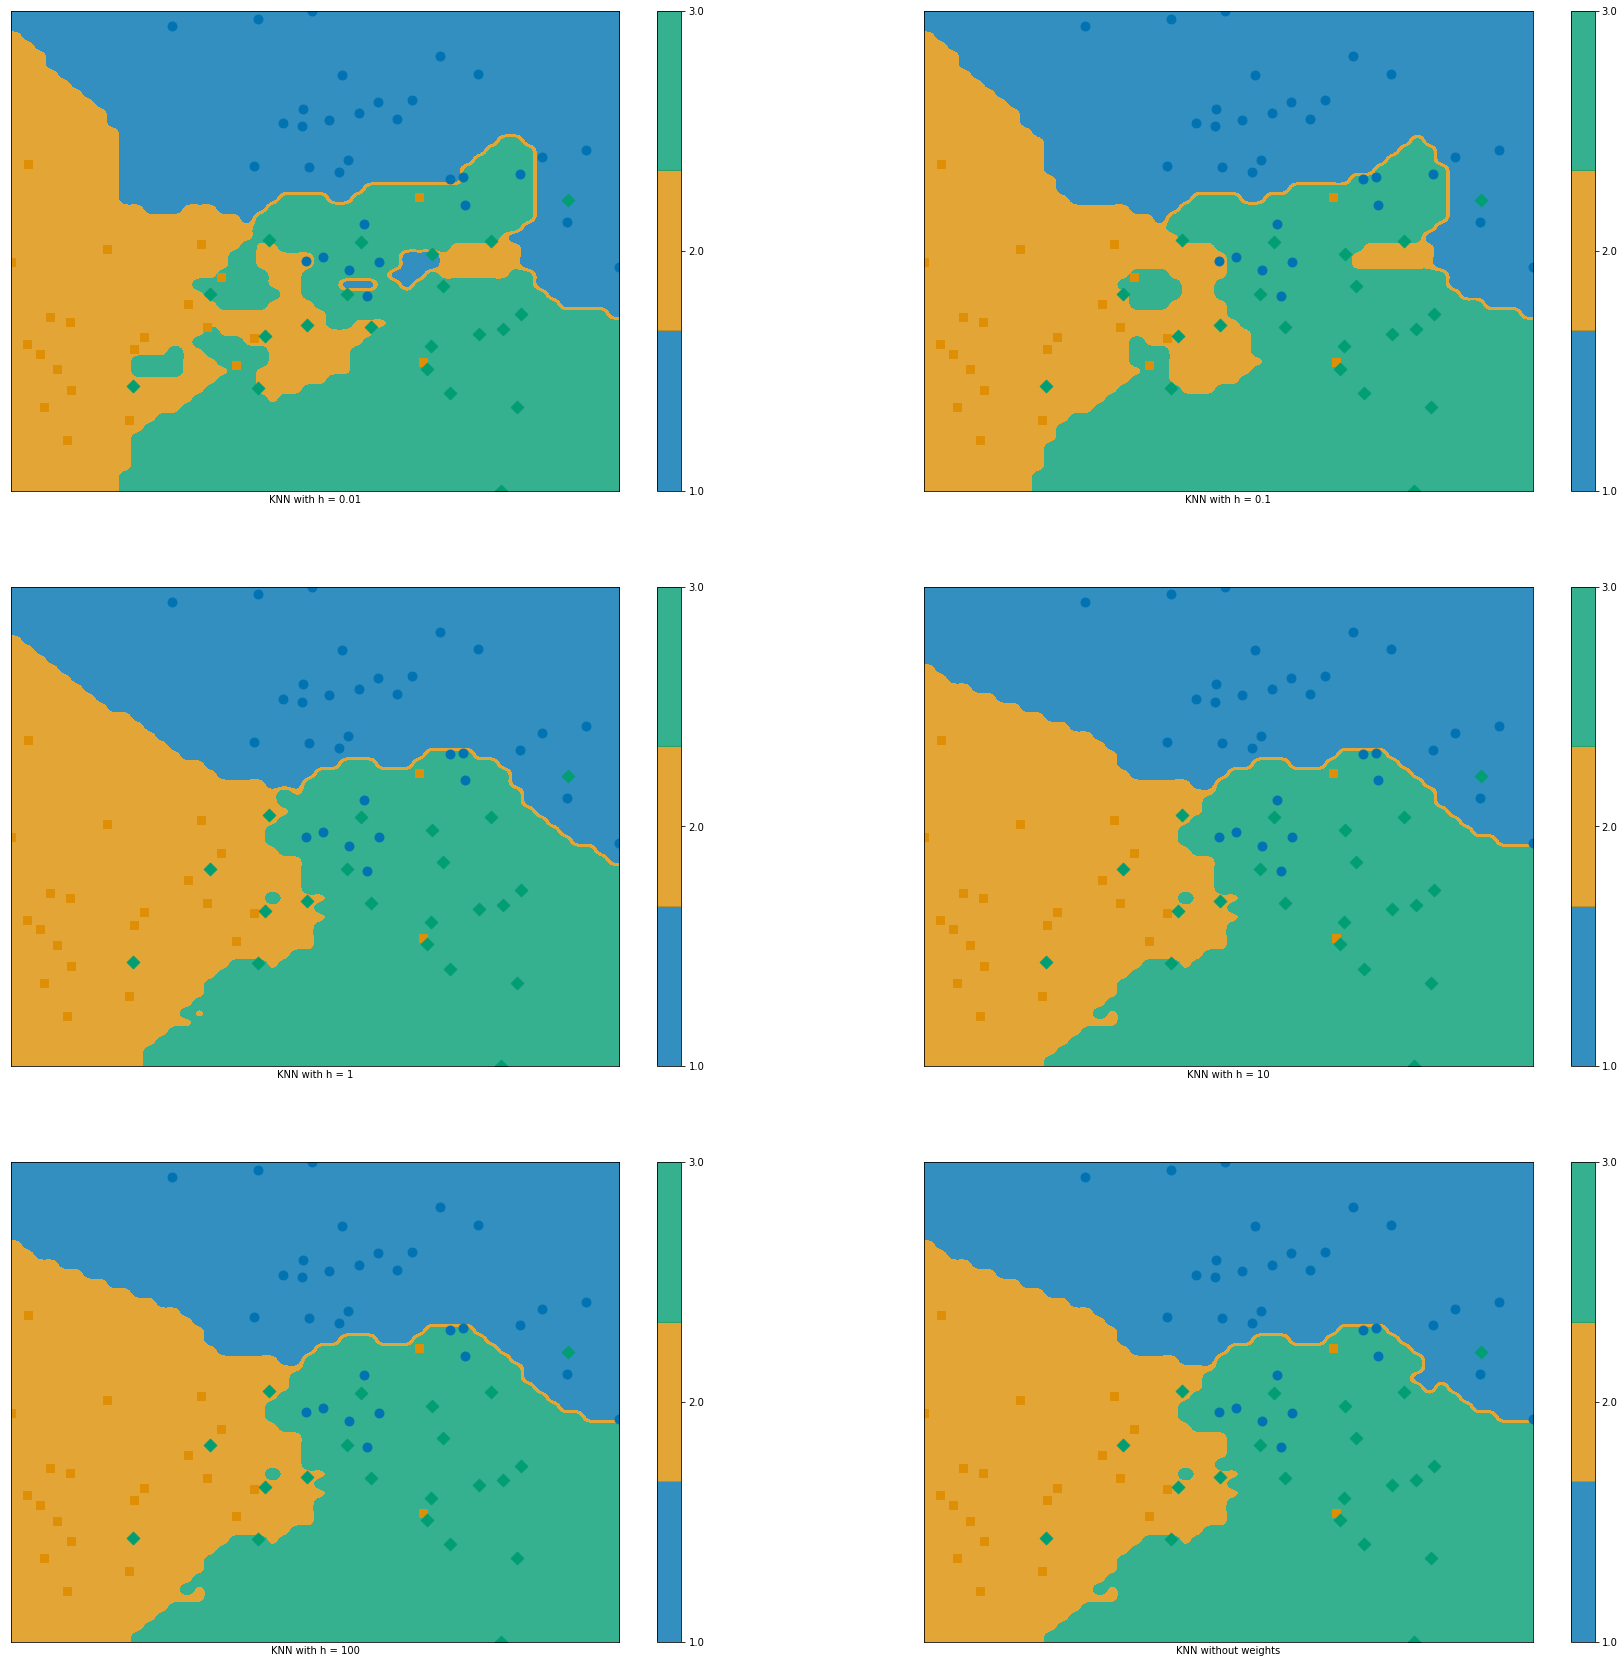

In [64]:
def weights(dist):
            h = 10**j
            w = np.exp(-dist**2/h)
            return w

def f_knn(x):
    return knn.predict(x)

fig = plt.figure(figsize=(30, 30))

j = -2
knn = KNeighborsClassifier(n_neighbors = 7, weights = weights)
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,1)  
plt.xlabel('KNN with h = 0.01')
frontiere_new(f_knn, X2[1::2], y2[1::2])

j = -1
knn = KNeighborsClassifier(n_neighbors = 7, weights = weights)
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,2)  
plt.xlabel('KNN with h = 0.1')
frontiere_new(f_knn, X2[1::2], y2[1::2])

j = 0
knn = KNeighborsClassifier(n_neighbors = 7, weights = weights)
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,3)  
plt.xlabel('KNN with h = 1')
frontiere_new(f_knn, X2[1::2], y2[1::2])

j = 1
knn = KNeighborsClassifier(n_neighbors = 7, weights = weights)
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,4)  
plt.xlabel('KNN with h = 10')
frontiere_new(f_knn, X2[1::2], y2[1::2])

j = 2
knn = KNeighborsClassifier(n_neighbors = 7, weights = weights)
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,5)  
plt.xlabel('KNN with h = 100')
frontiere_new(f_knn, X2[1::2], y2[1::2])

# without weights
knn = KNeighborsClassifier(n_neighbors = 7, weights = None )
knn.fit(X2[::2], y2[::2]) 
plt.subplot(3,2,6)  
plt.xlabel('KNN without weights')
frontiere_new(f_knn, X2[1::2], y2[1::2])

>**Interprétation :**                               
Lorsque $h \geqslant 1$, la pondération affecte peu les résultats et on retrouve ce que nous obtenons sans pondération.

#### Question 8 : Taux d'erreur sur les données d'apprentissage et les données de test
Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite
par le classifieur) lorsque $k = 1$ ? et sur des données de test (les observations d’indice pair) ?

In [72]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X2[::2], y2[::2])
error_rate_train = (1 - knn.score(X2[::2], y2[::2]))*100
print(f"\n Le taux d'erreur sur les données d'apprentissage est de {round(error_rate_train,2)} %")


 Le taux d'erreur sur les données d'apprentissage est de 0.0 %


>Nous avons donc surentraîné nos données. Nous sommes dans un cas classique d'"overfitting", il faudrait enlever un peu de complexité à notre modèle pour éviter cet "overfitting". 

In [73]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X2[::2], y2[::2])
error_rate_test = (1 - knn.score(X2[1::2], y2[1::2]))*100
print(f"\n Le taux d'erreur sur les données de test est de {round(error_rate_test,2)} %")


 Le taux d'erreur sur les données de test est de 29.33 %


#### Question 9 : Taux d'erreur en fonction de k
Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de $k$ pour $k = 1, 2, ..., 50$. Vous pourrez utiliser la classe fournie `ErrorCurve`.

In [ ]:
###############################################################################
#               Algorithms and functions
###############################################################################


class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))
